# Import Libraries

In [1]:
#Import libraries

from google.colab import files  
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build
from google.colab import drive 
from google.colab.patches import cv2_imshow

from io import BytesIO
import numpy as np
import pandas as pd
import sys, os, re, csv, codecs
from os import listdir
import cv2

import tensorflow as tf
import keras
from keras import preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras import models
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils.data_utils import get_file
from keras.preprocessing.image import img_to_array
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import decode_predictions

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import skimage
import scipy
from scipy import ndimage, misc
from PIL import Image
import glob
import sklearn
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import imutils
from imblearn.under_sampling import NearMiss

#Authentication gDrive

In [2]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive/MyDrive/vgg16/FineTuning/dataset

Mounted at /gdrive/
/gdrive/MyDrive/vgg16/FineTuning/dataset


# DataSet Upload

In [3]:
##Create a dataset for augmentation, training and testing

percorso_rete='./rete/'
percorso_no_rete='./no_rete/'


X_rete,y_rete=[],[]
X_no_rete,y_no_rete=[],[]


y_id = []
y_label = []


data_rete = os.listdir(percorso_rete)
data_no_rete = os.listdir(percorso_no_rete)

dim = (133,133)

#label:1 RETE
for filename in data_rete: 
    #for image in images:
    img = cv2.imread(os.path.join(percorso_rete,filename), cv2.IMREAD_UNCHANGED)
    #img=cv2.imread(filename) 
    img2 = cv2.resize(img , dim)
    # img2=preprocess_input(img2)
    X_rete.append(img2)
    y_rete.append(1) #y deve essere un numero dobbiamo passare il layer 
    y_id.append(filename)
    y_label.append(1)

#label:0 NO RETE
for filename in data_no_rete: 
    #for image in images:
    img = cv2.imread(os.path.join(percorso_no_rete,filename), cv2.IMREAD_UNCHANGED)
    img2 = cv2.resize(img , dim)
    # img2=preprocess_input(img2)
    X_no_rete.append(img2)
    y_no_rete.append(0) #y deve essere un numero dobbiamo passare il layer 
    y_id.append(filename)
    y_label.append(0)

#Array per il train e validation
X_rete = np.array(X_rete) 
y_rete = np.array(y_rete)
X_no_rete=np.array(X_no_rete)
y_no_rete=np.array(y_no_rete)

print(X_rete.shape)
print(y_rete.shape)
print(X_no_rete.shape)
print(y_no_rete.shape)

X=np.concatenate((X_no_rete,X_rete),axis=0)
y=np.concatenate((y_no_rete,y_rete),axis=0)

print("Dim patch X : " + str(X.shape))
print("Dim label y : " + str(y.shape))


(828, 133, 133, 3)
(828,)
(764, 133, 133, 3)
(764,)
Dim patch X : (1592, 133, 133, 3)
Dim label y : (1592,)


In [4]:

percorso_rete_test='./patchCantiereTest/rete/'
percorso_no_rete_test='./patchCantiereTest/no_rete/'


X_rete_test,y_rete_test=[],[]
X_no_rete_test,y_no_rete_test=[],[]


y_id_test = []
y_label_test = []


data_rete_test = os.listdir(percorso_rete_test)
data_no_rete_test = os.listdir(percorso_no_rete_test)


#label:1 RETE
for filename in data_rete_test: 
    #for image in images:
    img = cv2.imread(os.path.join(percorso_rete_test,filename), cv2.IMREAD_UNCHANGED)
    #img=cv2.imread(filename) 
    img2 = cv2.resize(img , dim)
    # img2=preprocess_input(img2)
    X_rete_test.append(img2)
    y_rete_test.append(1) #y deve essere un numero dobbiamo passare il layer 
    y_id_test.append(filename)
    y_label_test.append(1)

#label:0 NO RETE
for filename in data_no_rete_test: 
    #for image in images:
    img = cv2.imread(os.path.join(percorso_no_rete_test,filename), cv2.IMREAD_UNCHANGED)
    img2 = cv2.resize(img , dim)
    # img2=preprocess_input(img2)
    X_no_rete_test.append(img2)
    y_no_rete_test.append(0) #y deve essere un numero dobbiamo passare il layer 
    y_id_test.append(filename)
    y_label_test.append(0)


#Array per il test
X_rete_test = np.array(X_rete_test) 
y_rete_test = np.array(y_rete_test)
X_no_rete_test =np.array(X_no_rete_test)
y_no_rete_test=np.array(y_no_rete_test)

print(X_rete_test.shape)
print(y_rete_test.shape)
print(X_no_rete_test.shape)
print(y_no_rete_test.shape)

X_test=np.concatenate((X_no_rete_test,X_rete_test),axis=0)
y_test=np.concatenate((y_no_rete_test,y_rete_test),axis=0)

print("Dim patch test : " + str(X_test.shape))
print("Dim label test : " + str(y_test.shape))


(252, 133, 133, 3)
(252,)
(81, 133, 133, 3)
(81,)
Dim patch test : (333, 133, 133, 3)
Dim label test : (333,)


In [5]:

df_test_id_label = pd.DataFrame({'id' : y_id_test,
                                 'label' : y_test})
print(df_test_id_label)

              id  label
0     test17.tif      0
1     test28.tif      0
2     test13.tif      0
3     test29.tif      0
4     test19.tif      0
..           ...    ...
328  test158.tif      1
329  test204.tif      1
330  test323.tif      1
331  test311.tif      1
332  test171.tif      1

[333 rows x 2 columns]


# Split DataSet

In [6]:
# Da applicare per test2 split 80/20

X_train, X_val, y_train, y_val=train_test_split(X,y,stratify=y, test_size=0.3)
#X_train_val, X_test, y_train_val, y_test=train_test_split(X,y,stratify=y, test_size=0.20) #train validation da una parte e test dall altra 
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,stratify=y_train_val, test_size= 0.25) #train e validation e divido ancora 


print("Dim validation : " + str(X_val.shape))
print("Dim train : " + str(X_train.shape))

Dim validation : (478, 133, 133, 3)
Dim train : (1114, 133, 133, 3)


In [ ]:
# da applicare per test1 split 60 /20 /20

# VERSIONE DA USARE CON DATAFRAME per test split 60/20/20
X_train_val, X_test, y_train_val, y_test=train_test_split(X,df['label'],stratify=df['label'], test_size=0.20, shuffle=True) #train validation da una parte e test dall altra 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,stratify=y_train_val, test_size= 0.25, shuffle=True) #train e validation e divido ancora 


print("dataset X_test : " + str(X_test.shape)) #323
print("dataset y_test : " + str(y_test.shape))


print("dataset X_test : " + str(X_test.shape))
print("dataset X_val : " + str(X_val.shape))
print("dataset X_train : " + str(X_train.shape))

print("dataset y_test : " + str(y_test.shape))
print("dataset y_val : " + str(y_val.shape))
print("dataset y_train : " + str(y_train.shape))


# versione con dataframe iniziale

#Mi porto dietro la chiave indice/nomefile per poter estrapolare il nome dell'immagine dopo aver fatto il test
print("---------------------------------------------------------------------------------")

df_test_id_label = pd.merge(y_test, df, left_index=True, right_index=True)
del df_test_id_label['label_x']
df_test_id_label.rename(columns = {'label_y' : 'label'}, inplace = True)
print(df_test_id_label)

print("---------------------------------------------------------------------------------")




Distribuzione rete - no rete nel dataset di test:
1    252
0     81
Name: label, dtype: int64
Distribuzione rete - no rete nel dataset di train:
1    579
0    535
Name: label, dtype: int64
Distribuzione rete - no rete nel dataset di validation:
1    249
0    229
Name: label, dtype: int64


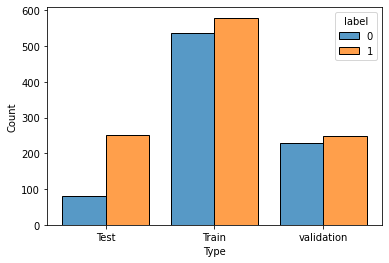

In [7]:
_test = pd.DataFrame({"label":y_test,
                        "Type" : "Test"})

_train = pd.DataFrame({"label":y_train,
                         "Type" : "Train"})

_val = pd.DataFrame({"label":y_val,
                       "Type" : "validation"})

_histplot = pd.concat([_test,_train,_val] , axis = 0)
_histplot.reset_index(inplace = True)

sns.histplot(data=_histplot, x="Type", hue="label", multiple="dodge", shrink=.8)
print("Distribuzione rete - no rete nel dataset di test:")
print(_test['label'].value_counts())
print("Distribuzione rete - no rete nel dataset di train:")
print(_train['label'].value_counts())
print("Distribuzione rete - no rete nel dataset di validation:")
print(_val['label'].value_counts())

#FUNCTIONS FOR DATA AUGMENTATION AND PREPROCESSING

In [8]:
#Function for data augmentation

X_train_aug=[]
y_train_aug=[]

def data_augmentation(X_train,y_train):

  for i in range(0,len(X_train)):

    horizontal_img = cv2.flip(X_train[i], 0)
    X_train_aug.append(horizontal_img)

    if y_train[i]==0:
      y_train_aug.append(0)
    else: 
      y_train_aug.append(1)

    vertical_img = cv2.flip(horizontal_img, 1)
    X_train_aug.append(vertical_img)
    
    if y_train[i]==0:
      y_train_aug.append(0)
    else: 
      y_train_aug.append(1)

  X_train=np.concatenate((X_train,X_train_aug ),axis=0)
  y_train=np.concatenate((y_train,y_train_aug ),axis=0)
  return X_train,y_train

In [9]:
#Data augmentation for both classes

print("Numero di patch prima dell'augmentation : " +  str(X_train.shape))
print( "Numero di label prima dell'augmentation : " + str(y_train.shape))

X_train_augmentated , y_train_augmentated = data_augmentation(X_train,y_train) 

print("Numero di patch dopo l'augmentation : " +  str(X_train_augmentated.shape))
print( "Numero di label dopo l'augmentation : " + str(y_train_augmentated.shape))


Numero di patch prima dell'augmentation : (1114, 133, 133, 3)
Numero di label prima dell'augmentation : (1114,)
Numero di patch dopo l'augmentation : (3342, 133, 133, 3)
Numero di label dopo l'augmentation : (3342,)


#FineTuing VGG16

In [10]:
X_train = X_train_augmentated
y_train = y_train_augmentated
y_train = to_categorical(y_train, num_classes = 2)

X_val = X_val
y_val = np.array(y_val)
y_val = to_categorical(y_val, num_classes = 2)

In [11]:
#Take the convolutional layers of VGG16 and freeze the first layers
img_rows = 133
img_cols = 133
vgg_conv = VGG16(include_top = False, weights ='imagenet', input_shape=(img_rows, img_cols, 3)) #
vgg_conv.summary()

# Freeze the all VGG16 layers except the last 4 CONV layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False  

for layer in vgg_conv.layers:       
    print(layer, layer.trainable)

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 133, 133, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 133, 133, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 133, 133, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 66, 66, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 66, 66, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 66, 66, 128)       147584    
                                                              

In [12]:
#Build a new model using the convolutional layers of VGG16 with (on top) some dense layers

model_tune = models.Sequential()
 
# Add the vgg convolutional base model
model_tune.add(vgg_conv)
 
# Add new layers (by default, kernel_initializer = 'glorot_uniform')
model_tune.add(layers.Flatten())
model_tune.add(layers.Dense(1024, activation='relu'))
model_tune.add(layers.Dense(512, activation='relu'))
#model_tune.add(layers.Dense(512, activation='relu'))
model_tune.add(layers.Dense(2, activation='softmax'))

#model_tune.add(Dense(1, activation='sigmoid'))
 
# Show a summary of the model. Check the number of trainable parameters
model_tune.summary()
model_tune.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),metrics=["accuracy"]) 
#model_tune.compile(loss="binary_crossentropy", optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),metrics=["accuracy"]) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 23,630,146
Trainable params: 15,994,882
Non-trainable params: 7,635,264
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [13]:
#Perform fine tuning using the training set (validation during fine tuning is performed on the validation set)
mc = ModelCheckpoint('./best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
history = model_tune.fit(X_train, y_train, epochs=30, verbose=1, validation_data = (X_val, y_val), shuffle=True, callbacks=[callback, mc])

Epoch 1/30
105/105 [==============================] - ETA: 0s - loss: 0.2641 - accuracy: 0.9354
Epoch 1: val_loss improved from inf to 0.15266, saving model to ./best_model.h5
105/105 [==============================] - 795s 8s/step - loss: 0.2641 - accuracy: 0.9354 - val_loss: 0.1527 - val_accuracy: 0.9707
Epoch 2/30
105/105 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9925
Epoch 2: val_loss improved from 0.15266 to 0.12773, saving model to ./best_model.h5
105/105 [==============================] - 802s 8s/step - loss: 0.0258 - accuracy: 0.9925 - val_loss: 0.1277 - val_accuracy: 0.9728
Epoch 3/30
105/105 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9985
Epoch 3: val_loss did not improve from 0.12773
105/105 [==============================] - 799s 8s/step - loss: 0.0090 - accuracy: 0.9985 - val_loss: 0.1347 - val_accuracy: 0.9728
Epoch 4/30
105/105 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000
Epoch 4: 

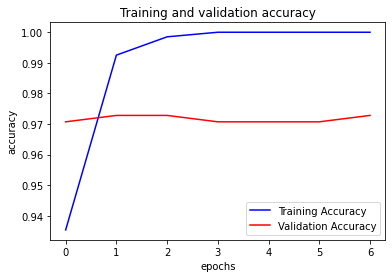

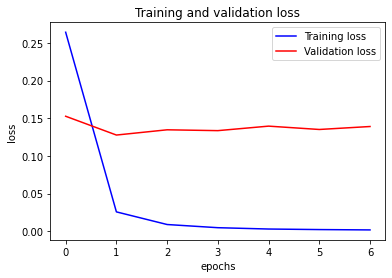

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.legend()
plt.figure() 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend() 
plt.show()

#Saving Model and weights

In [ ]:
!mkdir './MODEL-WEIGHTS-FINETUNING_test3' 

mkdir: cannot create directory ‘./MODEL-WEIGHTS-FINETUNING_test3’: File exists


In [ ]:
ls

confusion_matrix.png    MODEL-WEIGHTS-FINETUNING_test2/  patchCantiereTest/
DataSetPrint3Cantiere/  MODEL-WEIGHTS-FINETUNING_test3/  rete/
DataSetPrintTest/       no_rete/                         risultati.csv


In [ ]:
model_json_tuned = model_tune.to_json()
with open("./MODEL-WEIGHTS-FINETUNING_test3/model_tuned.json", "w") as json_file:
    json_file.write(model_json_tuned)
model_tune.save_weights("./MODEL-WEIGHTS-FINETUNING_test3/model_tuned.h5")
print("Model and weights saved")

Model and weights saved


#Prediction

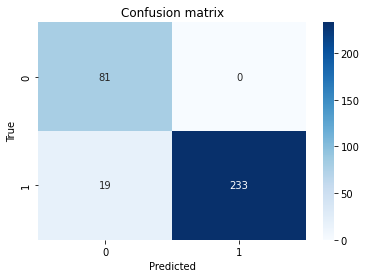

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        81
           1       1.00      0.92      0.96       252

    accuracy                           0.94       333
   macro avg       0.91      0.96      0.93       333
weighted avg       0.95      0.94      0.94       333



In [15]:
y_predicted = model_tune.predict(X_test) #contiene le probabilità
pred_class = np.argmax(y_predicted, axis = 1) 

matrix = confusion_matrix(y_test, pred_class)

fig = plt.figure()
sns.heatmap(matrix, annot=True, fmt="d",cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
fig.savefig('confusion_matrix.png')
plt.show()

print(sklearn.metrics.classification_report(y_test, pred_class))

report = sklearn.metrics.classification_report(y_test, pred_class, output_dict=True)
df = pd.DataFrame(report).transpose()

df.to_csv(path_or_buf='./risultati.csv', sep=',', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, mode='w', encoding=None,
                 compression='infer', quoting=None, quotechar='"', line_terminator=None, chunksize=None, date_format=None, doublequote=True, escapechar=None,
                 decimal='.', errors='strict', storage_options=None)



0 ==> No Rete 

1 ==> Rete 

Predicted : 0
Correct label : 1
Percentage 0: 99.998%
Percentage 1: 0.002%


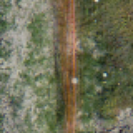

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 99.365%
Percentage 1: 0.635%


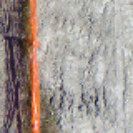

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 86.312%
Percentage 1: 13.688%


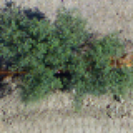

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 99.996%
Percentage 1: 0.004%


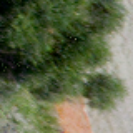

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 100.000%
Percentage 1: 0.000%


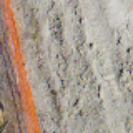

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 58.866%
Percentage 1: 41.134%


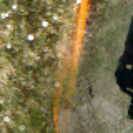

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 97.604%
Percentage 1: 2.396%


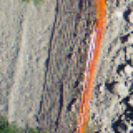

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 100.000%
Percentage 1: 0.000%


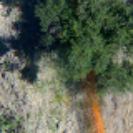

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 100.000%
Percentage 1: 0.000%


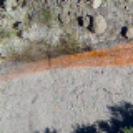

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 99.219%
Percentage 1: 0.781%


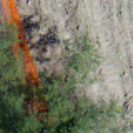

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 99.816%
Percentage 1: 0.184%


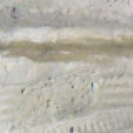

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 100.000%
Percentage 1: 0.000%


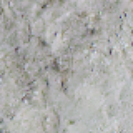

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 100.000%
Percentage 1: 0.000%


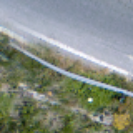

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 97.088%
Percentage 1: 2.912%


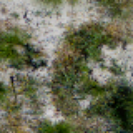

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 99.766%
Percentage 1: 0.234%


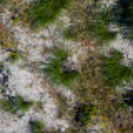

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 100.000%
Percentage 1: 0.000%


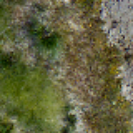

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 99.986%
Percentage 1: 0.014%


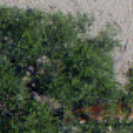

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 100.000%
Percentage 1: 0.000%


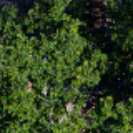

-------------------------------------------------------------------

Predicted : 0
Correct label : 1
Percentage 0: 99.983%
Percentage 1: 0.017%


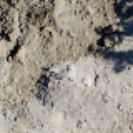

-------------------------------------------------------------------



In [16]:
patch_all = "./DataSetPrint3Cantiere/"

label_0, label_1 = [],[]

for pos in y_predicted:
  
  label_0.append("{:.3%}".format(pos[0]))
  label_1.append("{:.3%}".format(pos[1]))
  

_df = pd.DataFrame({'predicted' : pred_class,
                    'label' : df_test_id_label['label'],
                    'percent_0' : label_0,
                    'percent_1' : label_1,
                    'id' : df_test_id_label['id']})


_df1 = _df.loc[_df['predicted'] != _df['label']]

f=0

print("0 ==> No Rete \n")
print("1 ==> Rete \n")
for filename in _df1['id']:
    
    predicted = _df1['predicted'].iloc[f]
    label = _df1['label'].iloc[f]
    percentage_0 = _df1['percent_0'].iloc[f]
    percentage_1 = _df1['percent_1'].iloc[f]
    print("Predicted : " + str(predicted))
    print("Correct label : " + str(label))

    print("Percentage 0: " + str(percentage_0))
    print("Percentage 1: " + str(percentage_1))

    img = cv2.imread(os.path.join(patch_all,filename), cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img , dim)
    cv2_imshow(img)
    print("-------------------------------------------------------------------\n")
    f+=1
